<a href="https://colab.research.google.com/github/Garv-Patel/Garv-Patel/blob/main/prac10_stereo_and_3d_starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Remember to set the runtime to T4.
# Let's download some data and install dependencies.
from IPython.display import clear_output

# Clone the PSMNet repository
!git clone https://github.com/JiaRenChang/PSMNet.git
%cd PSMNet
# Download the pre-trained model for KITTI 2015
!wget https://drive.google.com/uc?id=1pHWjmhKMG4ffCrpcsp_MTXMJXhgl3kF9 -O pretrained_model_KITTI2015.tar
# Install torch geometric
!pip install torch_geometric

clear_output()
print("All data downloaded and dependencies installed.")

All data downloaded and dependencies installed.


---

# Exercise 1 - Stereo Depth Estimation Using PSMNet

Stereo depth estimation calculates depth from a pair of images taken by two horizontally aligned cameras. It works by finding corresponding points in both images and measuring their horizontal pixel displacement (disparity). The Pyramid Stereo Matching Network (PSMNet) is a deep learning model designed for this task. The key network components include:

1. **Spatial Pyramid Pooling (SPP)**: Captures global context at multiple scales. The SPP processes the input feature maps at multiple spatial scales, and then upsamples the pooled features to a common size and concatenates.
2. **Stacked Hourglass Architecture**: This architecture includes downsampling, bottleneck, and upsampling layers, much like an hourglass. Multiple hourglass structures are stacked one after another.
3. **Output**: Regresses a continuous disparity map.

In this exercise, we will use the PSMNet for stereo disparity estimation, then convert the disparity maps to read depth maps using camera intrinsics.

## Steps:

1. **Load and Preprocess Stereo Images**:
   - Load the left and right images of a stereo pair.
   - Preprocess the images to fit the input requirements of PSMNet.

2. **Disparity Prediction with a Pre-trained PSMNet Model**:
   - Initialise the PSMNet model architecture.
   - Load pre-trained weights for the KITTI 2015 (autonomous driving) dataset.
   - Pass the preprocessed stereo images through the PSMNet model.

3. **Convert Disparity to Depth**:
   - Implement a function to convert disparity to depth using camera parameters.
   - Visualise results.

Experiment with your own stereo rectified image pairs to evaluate the performance of PSMNet.

/content/PSMNet/models/submodule.py:115: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  output_branch1 = F.upsample(output_branch1, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')
/content/PSMNet/models/submodule.py:118: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  output_branch2 = F.upsample(output_branch2, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')
/content/PSMNet/models/submodule.py:121: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  output_branch3 = F.upsample(output_branch3, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')
/content/PSMNet/models/submodule.py:124: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  output_branch4 = F.upsample(output_branch4, (output_skip.size()[2],output_skip.size()[3]),mode='bilinear')
/content/PSMNet/models/s

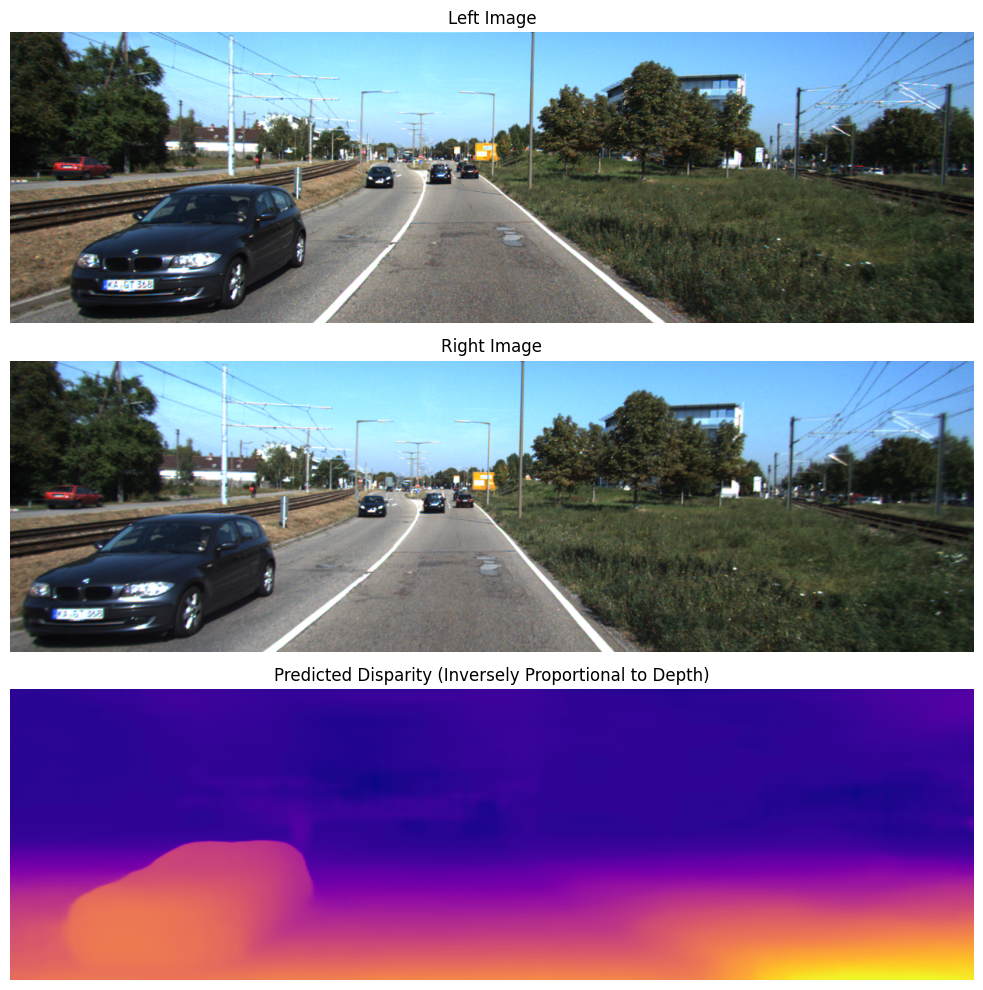

In [ ]:
# Use a pre-trained PSMNet to prediction stereo disparity
# Some imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from models.stackhourglass import PSMNet

# Load the pre-trained PSMNet model
model = PSMNet(maxdisp=192)
model = nn.DataParallel(model)
model.cuda()  # Move the model to the GPU
state_dict = torch.load('pretrained_model_KITTI2015.tar', map_location='cuda', weights_only=True)  # Load the pre-trained weights
model.load_state_dict(state_dict['state_dict'])
model.eval()  # Set the model to evaluation mode

# Preprocess stereo images
def preprocess_image(img_path):
    img = Image.open(img_path)
    img = torch.from_numpy(np.array(img).transpose(2, 0, 1)).float() / 255.0  # Convert to PyTorch tensor, reshape dimensions and normalise
    img = F.interpolate(img.unsqueeze(0), size=(256, 512), mode='bilinear', align_corners=False).squeeze(0)  # Resize image to match PSMNet input size
    return img

# Evaluation function
def evaluate(imgL, imgR):
    imgL = imgL.unsqueeze(0).cuda()
    imgR = imgR.unsqueeze(0).cuda()





    pred_disp = output.data.cpu().numpy().squeeze()
    return pred_disp

# Load images
left_img_path = '/content/18_l.png' # Test 20_l.png and 10_r.png as well
right_img_path = '/content/18_r.png'
left_img = Image.open(left_img_path)
right_img = Image.open(right_img_path)

# Preprocess images for model input
processed_left =
processed_right =

# Evaluate
disparity =

# Resize disparity map
disparity_image = Image.fromarray(disparity.astype(np.float32))
disparity_resized = disparity_image.resize(left_img.size, Image.BILINEAR)
disparity_resized = np.array(disparity_resized)

# Visualise result
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

ax1.imshow(left_img)
ax1.set_title('Left Image')
ax1.axis('off')

ax2.imshow(right_img)
ax2.set_title('Right Image')
ax2.axis('off')

ax3.imshow(disparity_resized, cmap='plasma')
ax3.set_title('Predicted Disparity (Inversely Proportional to Depth)')
ax3.axis('off')

plt.tight_layout()
plt.show()

## The Stereo Camera Setup

A stereo camera setup consists of two cameras positioned at a known distance apart (baseline). This configuration captures two images of the same scene from slightly different viewpoints, similar to how human eyes perceive depth. The key components of a stereo camera setup are:

- **Cameras**: Two identical cameras are used to capture images simultaneously. They should have the same specifications (e.g., lens, sensor) to ensure consistent image quality.

- **Baseline (B)**: The distance between the optical centers of the two cameras. A larger baseline can provide better depth resolution, but it can also lead to increased disparity, which may complicate depth calculations.

- **Calibration**: Accurate calibration of the camera parameters (intrinsic and extrinsic) is crucial for effective depth estimation. Intrinsic parameters include the focal length and principal point, while extrinsic parameters describe the spatial relationship between the two cameras.

- **Rectification**: Before computing disparity, the captured images are often rectified to align corresponding points in both images. This process transforms the images so that corresponding points lie on the same horizontal line, simplifying disparity calculation.

By analyzing the differences (disparities) between the two images, we can infer depth information about the scene.

## Converting Disparity to Depth

Disparity maps tell us how much a pixel in the left image has shifted compared to the right image, but they don’t directly give us depth in real-world units (e.g., meters). To convert the disparity into depth, we need to use the following formula:

$$
Z = \frac{f \cdot B}{d}
$$

Where:
- **Z** is the depth (distance from the camera).
- **f** is the focal length of the camera (intrinsic parameter).
- **B** is the baseline (distance between the two cameras).
- **d** is the disparity value from the disparity map.


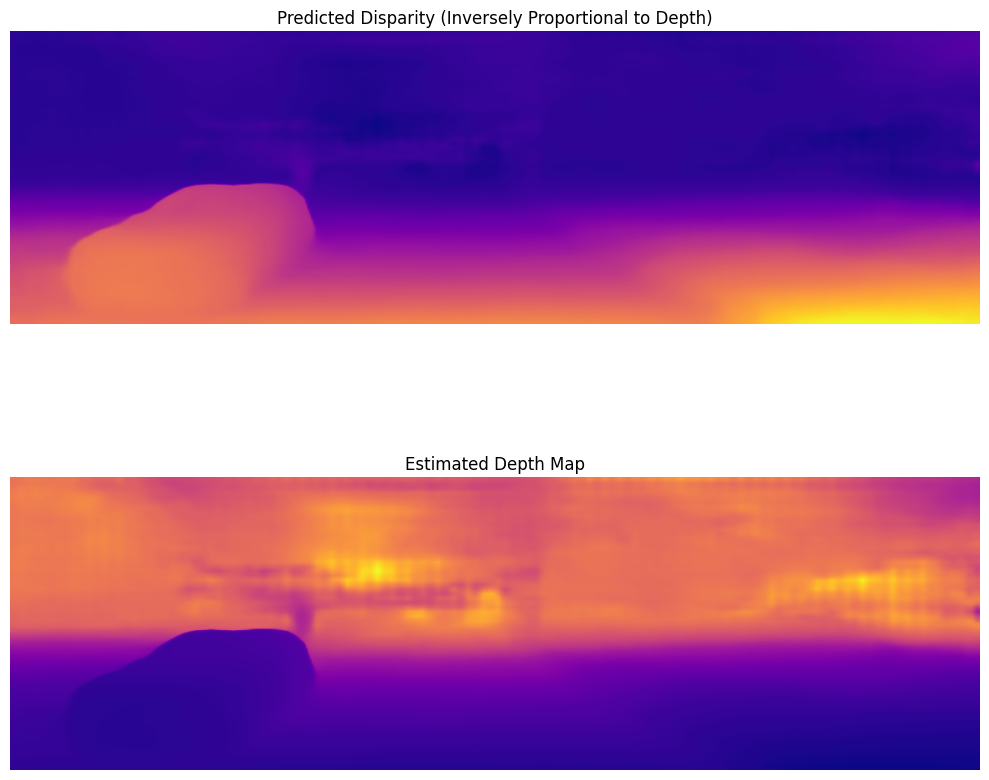

In [ ]:
# Conver the stereo disparity map to depth map

def disparity_to_depth(disparity, baseline, focal_length):



    return depth

# Calculate depth map, below are the camera intrinsics for the KITTI dataset
baseline = 0.54  # in meters, 54 centimeters
focal_length = 721.5377  # in pixels
depth_map =

# Visualise Disparity and Depth Maps
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Disparity Map
disparity_plot = ax1.imshow(disparity_resized, cmap='plasma')
ax1.set_title('Predicted Disparity (Inversely Proportional to Depth)')
ax1.axis('off')

# Depth Map
depth_plot = ax2.imshow(depth_map, cmap='plasma')
ax2.set_title('Estimated Depth Map')
ax2.axis('off')

plt.tight_layout()
plt.show()

---

# Exercise 2 - PointNet for Point Cloud Classification

PointNet is a deep neural network designed for classifying and segmenting point cloud data, which consists of a set of points in 3D space. It processes unordered point sets and is robust to permutations of input points. The key components of PointNet include:

1. **Input Transformation Network (TNet)**: This component learns to align the input point cloud to a canonical space. The T-Net predicts an affine transformation matrix that is applied directly to the input point coordinates.
2. **Feature Transformation**:  After the input transformation, each point is processed independently and identically using shared MLPs. These MLPs map the 3D point coordinates to a higher-dimensional feature space.
3. **Feature Transformation TNet**: The output of the feature extraction stage (per-point features) is passed through a second T-net. This T-net predicts a  transformation matrix to align the feature space.
4. **Output**: For classification, the global feature vector is passed through fully connected layers followed by a softmax layer to predict class probabilities for the input point cloud.


In this exercise, we will implement and train the PointNet model for classifying geometric shapes from point cloud data, sampled from the GeometricShapes dataset.


## Steps:

1. **Load the Point Cloud Dataset**:
   - Load the GeometricShapes dataset using PyTorch Geometric.
   - Transform the dataset to sample a fixed number of points.
   - Visualise the sampled point cloud in 3D.

2. **Implement TNet**:
   - Implement the TNet class, which will be used for input and feature transformations. This class should contain a sequential model that applies several linear layers followed by ReLU activations.

2. **Implement PointNet**:
   - Create the PointNet architecture that includes input and feature transformation networks, as well as MLP layers for feature extraction and classification. Implement the forward pass method.

3. **Train PointNet**:
   - Set up the optimiser and loss function.
   - Implement the training loop using mixed precision for efficiency.
   - Run the training loop for a specified number of epochs (e.g., 200). Print the training loss and test accuracy at the end of each epoch.

Extracting data/GeometricShapes/raw.zip
Processing...
Done!
<ipython-input-4-ac8b1be32ae9>:32: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim(np.min(pos[:, 2]), np.max(pos[:, 2]))


Dataset: GeometricShapes(40)
Number of samples in the dataset: 40


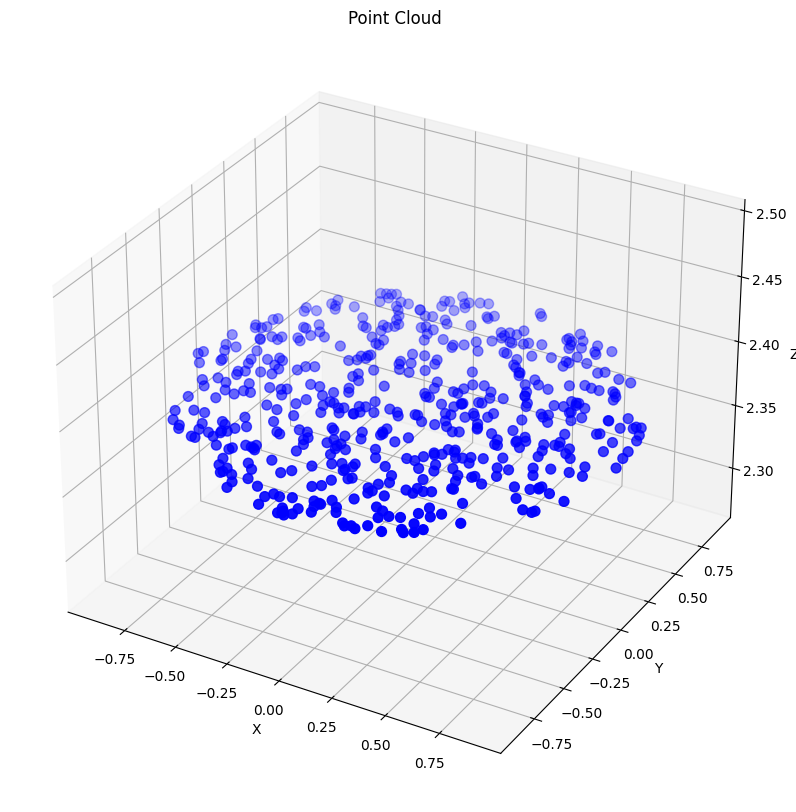

In [ ]:
# Visualise some sample point cloud data

from torch_geometric.datasets import GeometricShapes
import torch_geometric.transforms as T

# Load the GeometricShapes dataset
num_points = 512  # Specify the number of points you want to sample from the model objects
dataset = GeometricShapes(root='data/GeometricShapes', transform=T.SamplePoints(num=num_points))

# Display the dataset summary
print("Dataset:", dataset)
print("Number of samples in the dataset:", len(dataset))

# Pick a sample from the dataset
data = data[0]

# Visualise the sampled point cloud
def plot_points(data):
    # Get the positions
    pos = data.pos.numpy()

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the points
    ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c='b', marker='o', s=50)  # Blue points

    # Set plot limits
    ax.set_xlim(np.min(pos[:, 0]), np.max(pos[:, 0]))
    ax.set_ylim(np.min(pos[:, 1]), np.max(pos[:, 1]))
    ax.set_zlim(np.min(pos[:, 2]), np.max(pos[:, 2]))

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.title('Point Cloud')
    plt.show()

# Call the function to plot the points
plot_points(data)


---

## Mixed Precision Training

Mixed precision training is a technique that allows deep learning models to use both 16-bit and 32-bit floating point types for computations, leading to increased performance and reduced memory usage. PyTorch provides an API for implementing mixed precision training via the `torch.amp` module.

### PyTorch Classes

#### 1. `autocast`

- **Purpose**: The `autocast` context manager automatically manages the precision of operations. Within its scope, PyTorch will use float16 for certain operations that are safe to perform in lower precision, while still using float32 where necessary to maintain numerical stability.
- **Usage**: By wrapping the model's forward pass and loss calculation in `autocast`, you enable mixed precision for those operations without needing to manually specify the precision for each tensor.

    ```python
    with autocast(device_type='cuda'):
        logits = model(data.pos, data.batch)  # Forward pass with mixed precision
        loss = criterion(logits, data.y)  # Loss calculation
    ```

#### 2. `GradScaler`

- **Purpose**: The `GradScaler` is designed to prevent underflow during backpropagation when using float16. It scales the loss value before backpropagation and subsequently unscales the gradients before the optimizer step.
- **Usage**: It is used in conjunction with the `autocast` context manager to manage gradient scaling during training:

    ```python
    scaler = GradScaler()  # Initialize the gradient scaler

    # Scale the loss and backpropagate
    scaler.scale(loss).backward()  # Backpropagate the scaled loss
    scaler.step(optimizer)  # Update the model parameters
    scaler.update()  # Update the scaler for the next iteration
    ```

### Advantages of Using Mixed Precision Training

- **Significant Performance Improvement**: Mixed precision training can significantly reduce computation time, especially on compatible hardware.
- **Memory Efficiency**: It reduces the memory footprint of your model, allowing for larger batch sizes or more complex models without exceeding GPU memory limits.



In [ ]:
# Implement and train PointNet using Pytorch

from torch import Tensor
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import global_max_pool
from torch.amp import autocast, GradScaler
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import SamplePoints

class TNet(torch.nn.Module):
    # TNet is used for input and feature transformations
    # The TNet class consists of layers transforming k input channels (e.g., 3 for 3D coordinates)
    # to 64, 128, 1024, 512, 256, and finally outputs a k × k transformation matrix (e.g., 9 for k=3).
    def __init__(self, k): # k is the number of input channels, e.g. 3 for (x,y,z) coordinates
        super().__init__()
        self.k = k
        self.mlp = Sequential(
            Linear(...), # First layer transforms k-dimensional input to 64 dimensions
            ReLU(),
            Linear(...),
            ReLU(),
            Linear(...),
            ReLU(),
            Linear(...),
            ReLU(),
            Linear(...),
            ReLU(),
            Linear(...) # Final layer outputs k*k dimensions for the transformation matrix
        )

    def forward(self, x):
        x = ...         # Forward pass through the MLP
        x = x.view(-1, self.k, self.k) # Reshape output to (batch_size, k, k) to form transformation matrices
        return x

class PointNet(torch.nn.Module):
    # The PointNet class initialises with two transformation networks (TNet) for input (3D coordinates) and features (64-dimensional),
    # followed by two multi-layer perceptrons (MLP) with layers transforming dimensions:
    # ( 3 → 64 → 64 ) and ( 64 → 128 → 1024 ) ,
    # and finally a classifier that transforms from 1024 to 512, 256, and outputs num_classes.
    def __init__(self, num_classes):
        super().__init__()
        self.input_transform = TNet(k=...) # Input transform for (x,y,z) coordinates
        self.feature_transform = TNet(k=...) # 3D feature transform

        self.mlp1 = Sequential(
            Linear(...),
            ReLU(),
            Linear(...)
        )

        self.mlp2 = Sequential(
            Linear(...),
            ReLU(),
            Linear(...)
        )

        self.classifier = Sequential(
            Linear(...),
            ReLU(),
            Linear(...),
            ReLU(),
            Linear(...)
        )

    def forward(self, points, batch):
        # Input transform
        trans = ...                                     # Generate the transformation matrix
        x = torch.bmm(points.unsqueeze(1), trans).squeeze(1) # Perform a batch matrix multiplication to apply the transformation matrix

        # MLP 1
        x = ...

        # Feature transform
        trans = ...                                     # Generate the transformation matrix
        x = torch.bmm(x.unsqueeze(1), trans).squeeze(1) # Perform a batch matrix multiplication to apply the transformation matrix

        # MLP 2
        x = ...

        # Global max pooling
        x = global_max_pool(x, batch)

        # Classifier
        x = ...

        return x

train_dataset = GeometricShapes(root='data/GeometricShapes', transform=T.SamplePoints(num=512), train=True)
test_dataset = GeometricShapes(root='data/GeometricShapes', transform=T.SamplePoints(num=512), train=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # Play around with batch size
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Ensure model is moved to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PointNet(num_classes=train_dataset.num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Use the Adam optimiser
criterion = torch.nn.CrossEntropyLoss() # Use the cross-entropy losee

# Use GradScaler and autocast from `torch.amp` to enable mixed precision
scaler = GradScaler()
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)  # Ensure data is on the same device
        optimizer.zero_grad()           # Clear gradients from last iteration
        with autocast(device_type='cuda'):  # Mixed precision enabled
            logits = model(data.pos, data.batch) # Forward pass
            loss = criterion(logits, data.y) # Compute the loss using the predictions and ground truth labels
        scaler.scale(loss).backward() # Back propagation using grad scaler
        scaler.step(optimizer)
        scaler.update()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad() # No gradiant updates for evaluation mode
def test():
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    for data in test_loader:
        data = data.to(device)  # Ensure data is on the same device
        logits = model(data.pos, data.batch)  # Forward pass
        pred = logits.argmax(dim=-1)  # Get predicted classes
        total_correct += int((pred == data.y).sum())  # Count correct predictions
    return total_correct / len(test_loader.dataset)  # Return accuracy

# Train model for 200 epochs
for epoch in range(1, 201):
    loss = train()
    test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 3.6895, Test Acc: 0.0500
Epoch: 002, Loss: 3.6888, Test Acc: 0.0750
Epoch: 003, Loss: 3.6852, Test Acc: 0.0500
Epoch: 004, Loss: 3.6628, Test Acc: 0.0250
Epoch: 005, Loss: 3.5550, Test Acc: 0.0500
Epoch: 006, Loss: 3.5069, Test Acc: 0.0500
Epoch: 007, Loss: 3.4651, Test Acc: 0.0750
Epoch: 008, Loss: 3.3910, Test Acc: 0.0750
Epoch: 009, Loss: 5.0675, Test Acc: 0.0750
Epoch: 010, Loss: 5.0927, Test Acc: 0.0750
Epoch: 011, Loss: 5.0900, Test Acc: 0.0750
Epoch: 012, Loss: 4.9567, Test Acc: 0.0750
Epoch: 013, Loss: 5.1317, Test Acc: 0.0750
Epoch: 014, Loss: 3.2769, Test Acc: 0.1250
Epoch: 015, Loss: 3.3060, Test Acc: 0.1000
Epoch: 016, Loss: 3.3500, Test Acc: 0.1250
Epoch: 017, Loss: 3.3114, Test Acc: 0.1000
Epoch: 018, Loss: 3.3063, Test Acc: 0.1000
Epoch: 019, Loss: 3.2977, Test Acc: 0.1250
Epoch: 020, Loss: 3.2342, Test Acc: 0.1250
Epoch: 021, Loss: 3.1710, Test Acc: 0.1250
Epoch: 022, Loss: 3.1231, Test Acc: 0.1250
Epoch: 023, Loss: 3.0283, Test Acc: 0.1250
Epoch: 024,